<a href="https://colab.research.google.com/github/earthspecies/open_collaboration_on_audio_classification/blob/master/Introduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
if 'google.colab' in sys.modules:
  !pip install git+git://github.com/fastai/fastai2.git
  !pip install torchaudio

In [1]:
from fastai2.vision.all import *
import torchaudio
import pathlib
from IPython.display import Audio
import torchaudio
import librosa # the librosa library makes it very convenient to work with audio files in Python

In [2]:
path = untar_data('https://archive.org/download/macaques_24414hz_202007/macaques_24414Hz.zip')

In [3]:
wav_files = get_files(path); wav_files

(#7285) [Path('/root/.fastai/data/macaques_24414Hz/AL/AL1.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL10.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL100.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL101.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL102.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL103.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL104.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL105.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL106.wav'),Path('/root/.fastai/data/macaques_24414Hz/AL/AL107.wav')...]

In [4]:
def get_items(path): return get_files(path)

In [5]:
def get_y(path): return path.parent.stem

In [6]:
n_fft=1024
hop_length=140
target_rate=24414
num_samples=int(0.3*target_rate)

In [7]:
au2spec = torchaudio.transforms.MelSpectrogram(sample_rate=target_rate,n_fft=n_fft, hop_length=hop_length, n_mels=64)
ampli2db = torchaudio.transforms.AmplitudeToDB()

In [8]:
def get_x(path, target_rate=target_rate, num_samples=num_samples):
    x, rate = torchaudio.load_wav(path)
    if rate != target_rate: 
        x = torchaudio.transforms.Resample(orig_freq=rate, new_freq=target_rate, resampling_method='sinc_interpolation')(x)
    x = x[0] / 32767
    x = x.numpy()
    x = librosa.util.fix_length(x, num_samples)
    torch_x = torch.tensor(x)
    spec = au2spec(torch_x)
    spec_db = ampli2db(spec)
    spec_db = spec_db.data.squeeze(0).numpy()
    spec_db = spec_db - spec_db.min()
    spec_db = spec_db/spec_db.max()*255
    return spec_db

In [9]:
db = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(seed=42))

In [10]:
dls = db.dataloaders(path, num_workers=2)

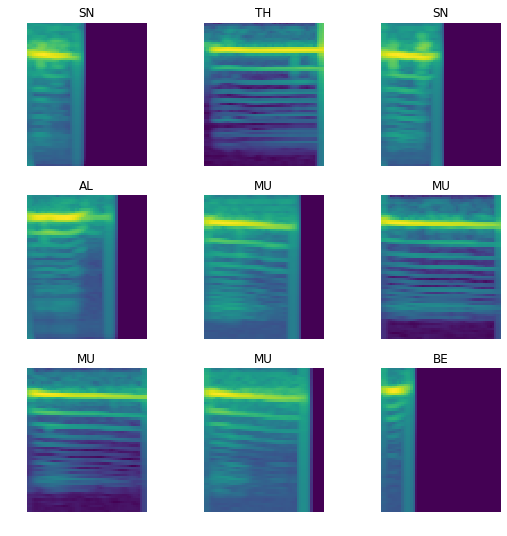

In [11]:
dls.show_batch()

In [12]:
# Thanks to Ad Postma for his fastaiaudio notebook showing how to train with xresnet
net = xresnet18()

In [13]:
learn = Learner(dls, net, metrics=error_rate)

In [14]:
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [15]:
nchannels = dls.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

In [16]:
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.182229,0.318864,0.098147,00:08


epoch,train_loss,valid_loss,error_rate,time
0,0.063065,0.061079,0.019904,00:08
1,0.051446,0.048071,0.015100,00:08
2,0.047925,0.102577,0.040494,00:07
3,0.026324,0.022279,0.006863,00:08
4,0.016488,0.014669,0.003432,00:07
5,0.006159,0.014640,0.004804,00:07
6,0.002446,0.009563,0.002745,00:08
7,0.001201,0.009920,0.002745,00:07
